## The Goal: Test differences in coupling strenth between: CESM2, CESM1, CESM2/CLM4.5  
<br>
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 14 Sep 2020 <br><br>

In [1]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
from ComputeLCLpressure_function import ComputeLCLpressure

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


In [2]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


## Read in CESM2 data

In [3]:
# Load in pickle files: 
dataDir = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_1979-2006.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_1979-2006.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_1979-2006.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CESM2  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM2 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM2  = xr.open_dataset(dataDir+file_LH,      decode_times=False)



## Read in CESM1 data
Note: These coupling indices have already been computed and saved on local laptop.

In [4]:
# Load in pickle files: 
dataDir = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM1.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM1.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM1.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CESM1  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM1 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM1  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


## Read in CESM2/CLM4.5 data
Note: This is new data, so need to compute (1) P_lcl, (2) Coupling indices [and save to file]

### Do the work of computing CI on Casper 

In [5]:
# Set directories for raw data 
cesmDir = '/glade/work/mdfowler/data/CESM2_clm4.5/'

startCLM = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h1.'
startCAM = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.'

endCLM = '_SOILWATER10CM.nc'
endFLX = '_sfcFluxes.nc'

timeName = ['1980-1989', '1990-1999', '2000-2005']



In [7]:
# Read in test file to get lat/lon 
fileName = cesmDir+startCAM+timeName[0]+endFLX
testDF   = xr.open_dataset(fileName, decode_times=True)

# Get lat and lon 
lat = testDF.lat.values
lon = testDF.lon.values 


In [9]:
# Read in flux files and get time as usable format 
file1 = cesmDir+startCAM+timeName[0]+endFLX 
flxDF = xr.open_dataset(file1, decode_times=True)
flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = cesmDir+startCAM+timeName[1]+endFLX 
flxDF2 = xr.open_dataset(file2, decode_times=True) 
flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = cesmDir+startCAM+timeName[2]+endFLX 
flxDF3 = xr.open_dataset(file3, decode_times=True) 
flxDF3['time'] = flxDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
flux_full  = xr.concat([flxDF,  flxDF2, flxDF3], dim="time")


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if __name__ == '__main__':


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


File 3 finished reading in...


In [11]:
# Read in soil moisture files and get time as usable format 
file1 = cesmDir+startCLM+timeName[0]+endCLM 
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = cesmDir+startCLM+timeName[1]+endCLM 
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = cesmDir+startCLM+timeName[2]+endCLM 
soilDF3 = xr.open_dataset(file3, decode_times=True) 
soilDF3['time'] = soilDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
soil_full  = xr.concat([soilDF,  soilDF2, soilDF3], dim="time")



/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if __name__ == '__main__':


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


File 3 finished reading in...


In [2]:
# Use newly created function to get LCL pressure
filesIn = np.asarray(['/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.1980-1989_refHTs.nc',
                      '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.1990-1999_refHTs.nc',
                      '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h1.2000-2005_refHTs.nc'])

fileOutName = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CLM45.p'

lclPath = ComputeLCLpressure(filesIn,'PS','TREFHT','RHREFHT',fileOutName)


Number of files: 

 3


/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/ComputeLCLpressure_function.py:36: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sfcDF['time'] = sfcDF.indexes['time'].to_datetimeindex()


File 1 finished reading in...
File 2 finished reading in...
File 2 concatenated
File 3 finished reading in...
File 3 concatenated
Data starts at:  1980-01-11T00:00:00.000000000
Data ends at:    2006-01-01T00:00:00.000000000
Done with  0.0  % of days
Done with  4.214785467419708  % of days
Done with  8.429570934839417  % of days
Done with  12.644356402259124  % of days
Done with  16.859141869678833  % of days
Done with  21.073927337098542  % of days
Done with  25.288712804518248  % of days
Done with  29.503498271937957  % of days
Done with  33.718283739357666  % of days
Done with  37.933069206777375  % of days
Finished computing LCL-pressure level successfully and saved pickle file:
/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CLM45.p


In [3]:
# Now read in Plcl from that path 
Plcl    = pickle.load( open( lclPath, "rb" ) )


In [12]:
# To be able to easily access years, months, days - use Pandas 
dates    = pd.DatetimeIndex(soil_full['time'].values)


In [13]:
# Read in land mask 
filePath = '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h1.1976-01-01-00000.nc'
exDF     = xr.open_dataset(filePath,decode_times=False)

landMask              = exDF.landmask.values.astype(float)
landMask[landMask==0] = np.nan


### Sanity check: do variables seem okay?

Text(0.5, 1.0, 'Pressure Level of LCL (time average)')

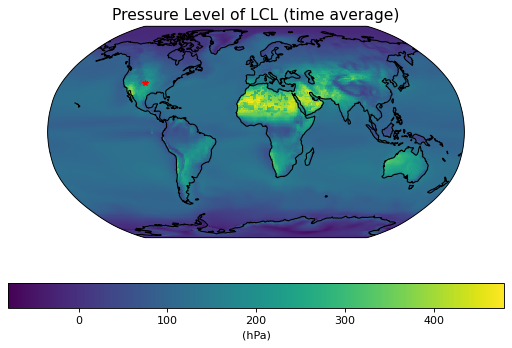

In [8]:
# Map out average pressure level of the LCL (in terms of height above sfc)

fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
Plcl_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(Plcl,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,Plcl_cyclic,transform=ccrs.PlateCarree())
ax.plot(lon_cyclic[206],lat[135],'r*',markersize=5,transform=ccrs.PlateCarree())   # Point for sanity check
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(hPa)',orientation='horizontal')
ax.set_title('Pressure Level of LCL (time average)', fontsize=14)


(726619.0, 726649.0)

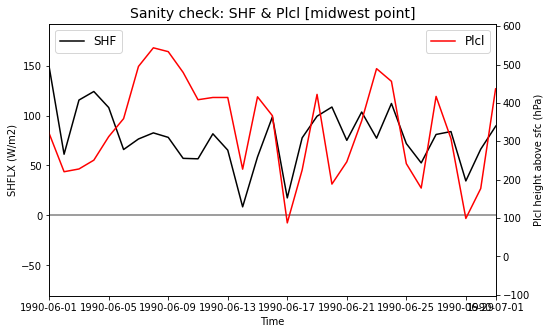

In [17]:
# Plot a timeseries of variables 

fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

ax1.plot(dates, flux_full.SHFLX.values[:,135,206],'k-')
ax1.set_ylabel('SHFLX (W/m2)')
ax1.set_xlabel('Time')
ax1.legend(['SHF'],loc='upper left',fontsize=12)
ax1.set_title('Sanity check: SHF & Plcl [midwest point]', fontsize=14)
ax1.axhline(0,color='gray')

ax2 = ax1.twinx()
ax2.plot(dates, Plcl[:,135,206], 'r-')
ax2.set_ylabel('Plcl height above sfc (hPa)')
ax2.legend(['Plcl'], loc='upper right',fontsize=12)

ax1.set_xlim([datetime.date(1990,6,1), datetime.date(1990,7,1)])



Text(0.5, 1.0, 'LHFLX (time mean, 1979-2004)')

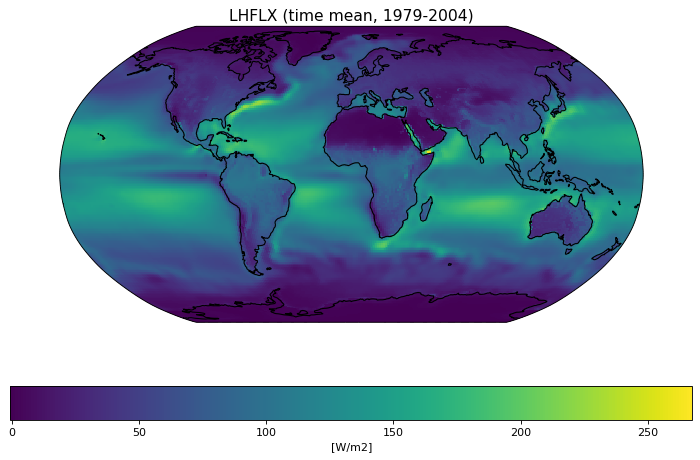

In [15]:
# How about latent heat flux? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
LHavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(flux_full.LHFLX.values,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,LHavg_cyclic,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[W/m2]',orientation='horizontal')
ax.set_title('LHFLX (time mean, 1980-2004)', fontsize=14)


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, '11-cm SM (time mean, 1980-2006)')

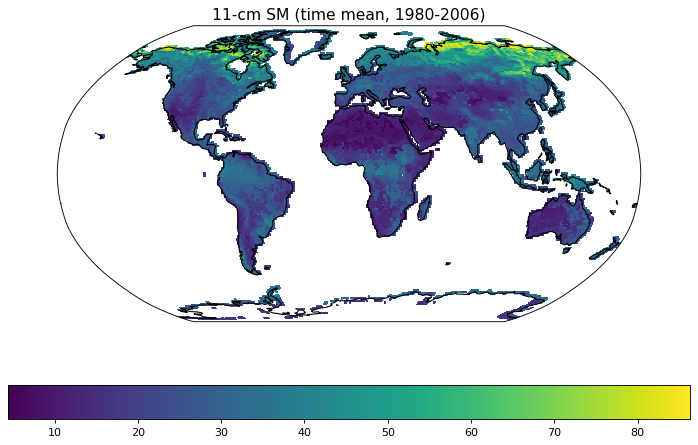

In [19]:
# How about SM? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
SMavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(soil_full.SOILWATER_10CM.values,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,
                             SMavg_cyclic,
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot,orientation='horizontal')
ax.set_title('10-cm SM (time mean, 1980-2006)', fontsize=14)


### Compute coupling index: LH & SM

In [20]:
# Make one big xr.Dataset containing all the information we need  
dFull = flux_full
dFull['soilM_10'] = (('time','lat','lon'), soil_full.SOILWATER_10CM.values)
dFull['Plcl'] = (('time','lat','lon'), Plcl)


In [21]:
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull, xname='soilM_10',yname='LHFLX',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_CESM2-CLM45.nc')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Terrestrial Coupling Index (10cm SM and LHFLX) [DJF]')

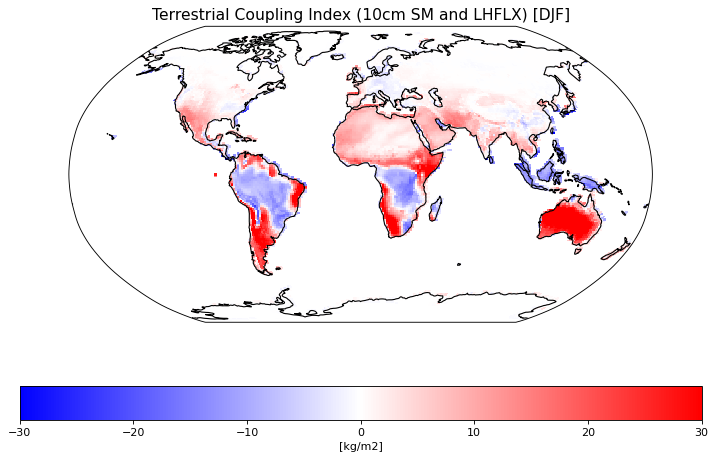

In [22]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
terraCoupl_DJF, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(terra_coupling.soilM_10_LHFLX_CI[0,:,:]), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,terraCoupl_DJF,vmin=-30,vmax=30,cmap='bwr',transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[kg/m2]',orientation='horizontal')
ax.set_title('Terrestrial Coupling Index (10cm SM and LHFLX) ['+np.asarray(terra_coupling.season)[0]+']', fontsize=14)



### Compute coupling indices: SH, SM, and P_lcl

In [23]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling = cm.metrics.CouplingIndex()
terraLeg_coupling = terraLeg_coupling.compute(dFull, xname='soilM_10',yname='SHFLX',averaging='season')

# Save to netCDF file
terraLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_CESM2-CLM45.nc')



/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [24]:
# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling = cm.metrics.CouplingIndex()
atmoLeg_coupling = atmoLeg_coupling.compute(dFull, xname='SHFLX',yname='Plcl',averaging='season')

# Save to netCDF file 
atmoLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts//Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_CESM2-CLM45.nc')


### Read in from files

In [5]:
# Load in pickle files: 
dataDir = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM2-CLM45.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM2-CLM45.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM2-CLM45.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CLM45  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CLM45 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CLM45  = xr.open_dataset(dataDir+file_LH,      decode_times=False)



## Read in CESM2/CAM5 data
Note: This is new data, so need to compute (1) P_lcl, (2) Coupling indices [and save to file]

### Again, compute on Casper

In [ ]:
# Set directories for raw data 
cesmDir = '/glade/work/mdfowler/data/CESM2_cam5/'

startCLM = 'f.e20.FHIST.f09_f09.cesm2_1_cam5.001.clm2.h0.'
startCAM = 'f.e20.FHIST.f09_f09.cesm2_1_cam5.001.cam.h0.'

endCLM = '_SOILWATER10.nc'
endFLX = '_sfcFluxes.nc'

timeName = ['1980-1989', '1990-1999', '2000-2005']




## Now plot some comparisons

### Set up color maps 

In [6]:
### Create a list of RGB tuples
colorsList_SMvLHF = [(127,58,144), 
                     (67,81,163),
                     (0,191,243),
                     (194,229,220),
                     (124,194,66),
                     (227,219,46),
                     (250,175,44),
                     (245,127,36), 
                     (239,67,54),
                     (238,45,122),
                     (162,6,66)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap_SMvLHF = make_cmap(colorsList_SMvLHF, bit=True)



### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB

my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)



### Create a list of RGB tuples for atmospheric leg (SHFLX, P_lcl)
colorsList_SHFvPlcl = [(172,183,209), 
                     (124,135,181),
                     (51,82,120),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58),
                     (136,90,59),
                     (214,48,44),
                     (224,93,126),
                     (242,189,177)] # This example uses the 8-bit RGB

my_cmap_SHFvPlcl = make_cmap(colorsList_SHFvPlcl, bit=True)


### Plots for LH-SM coupling index

In [11]:
lat = terraLH_CESM2.lat.values
lon = terraLH_CESM2.lon.values

In [12]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
LHcoupl_JJA_cesm1 = np.squeeze(np.asarray(terraLH_CESM1.soilM_10_LHFLX_CI[1,:,:]))
LHcoupl_DJF_cesm1 = np.squeeze(np.asarray(terraLH_CESM1.soilM_10_LHFLX_CI[0,:,:]))
LHcoupl_JJA_cesm2 = np.squeeze(np.asarray(terraLH_CESM2.mrsos_hfls_CI[1,:,:]))
LHcoupl_DJF_cesm2 = np.squeeze(np.asarray(terraLH_CESM2.mrsos_hfls_CI[0,:,:]))
LHcoupl_JJA_clm45 = np.squeeze(np.asarray(terraLH_CLM45.soilM_10_LHFLX_CI[1,:,:]))
LHcoupl_DJF_clm45 = np.squeeze(np.asarray(terraLH_CLM45.soilM_10_LHFLX_CI[0,:,:]))

# Make cyclic first 
LHcoupl_JJA_cyclic_cesm1, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_JJA_cesm1, lon)
LHcoupl_DJF_cyclic_cesm1, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_DJF_cesm1, lon)
LHcoupl_JJA_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_JJA_cesm2, lon)
LHcoupl_DJF_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_DJF_cesm2, lon)
LHcoupl_JJA_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_JJA_clm45, lon)
LHcoupl_DJF_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(LHcoupl_DJF_clm45, lon)

# Now get color coded arrays 
colorsSMvLHF_JJA_cesm1 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_DJF_cesm1 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_JJA_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_DJF_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_JJA_clm45 = np.full([len(lat),len(lon)+1],np.nan)
colorsSMvLHF_DJF_clm45 = np.full([len(lat),len(lon)+1],np.nan)


# ----- CESM 1 ---------

# JJA 
colorsSMvLHF_JJA_cesm1[np.where(LHcoupl_JJA_cyclic_cesm1<-15)]                                = 1
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-15) & (LHcoupl_JJA_cyclic_cesm1<=-10))]  = 2
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-10) & (LHcoupl_JJA_cyclic_cesm1<=-5))]   = 3
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>-5)  & (LHcoupl_JJA_cyclic_cesm1<=5))]    = 4
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>5)   & (LHcoupl_JJA_cyclic_cesm1<=10))]   = 5
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>10)  & (LHcoupl_JJA_cyclic_cesm1<=15))]   = 6
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>15)  & (LHcoupl_JJA_cyclic_cesm1<=20))]   = 7
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>20)  & (LHcoupl_JJA_cyclic_cesm1<=25))]   = 8
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>25)  & (LHcoupl_JJA_cyclic_cesm1<=30))]   = 9
colorsSMvLHF_JJA_cesm1[np.where((LHcoupl_JJA_cyclic_cesm1>30)  & (LHcoupl_JJA_cyclic_cesm1<=35))]   = 10
colorsSMvLHF_JJA_cesm1[np.where(LHcoupl_JJA_cyclic_cesm1>35)]                                 = 11

# DJF 
colorsSMvLHF_DJF_cesm1[np.where(LHcoupl_DJF_cyclic_cesm1<-15)]                                = 1
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>-15) & (LHcoupl_DJF_cyclic_cesm1<=-10))]  = 2
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>-10) & (LHcoupl_DJF_cyclic_cesm1<=-5))]   = 3
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>-5)  & (LHcoupl_DJF_cyclic_cesm1<=5))]    = 4
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>5)   & (LHcoupl_DJF_cyclic_cesm1<=10))]   = 5
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>10)  & (LHcoupl_DJF_cyclic_cesm1<=15))]   = 6
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>15)  & (LHcoupl_DJF_cyclic_cesm1<=20))]   = 7
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>20)  & (LHcoupl_DJF_cyclic_cesm1<=25))]   = 8
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>25)  & (LHcoupl_DJF_cyclic_cesm1<=30))]   = 9
colorsSMvLHF_DJF_cesm1[np.where((LHcoupl_DJF_cyclic_cesm1>30)  & (LHcoupl_DJF_cyclic_cesm1<=35))]   = 10
colorsSMvLHF_DJF_cesm1[np.where(LHcoupl_DJF_cyclic_cesm1>35)]                                 = 11


# ----- CESM 2 ---------

# JJA 
colorsSMvLHF_JJA_cesm2[np.where(LHcoupl_JJA_cyclic_cesm2<-15)]                                = 1
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>-15) & (LHcoupl_JJA_cyclic_cesm2<=-10))]  = 2
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>-10) & (LHcoupl_JJA_cyclic_cesm2<=-5))]   = 3
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>-5)  & (LHcoupl_JJA_cyclic_cesm2<=5))]    = 4
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>5)   & (LHcoupl_JJA_cyclic_cesm2<=10))]   = 5
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>10)  & (LHcoupl_JJA_cyclic_cesm2<=15))]   = 6
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>15)  & (LHcoupl_JJA_cyclic_cesm2<=20))]   = 7
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>20)  & (LHcoupl_JJA_cyclic_cesm2<=25))]   = 8
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>25)  & (LHcoupl_JJA_cyclic_cesm2<=30))]   = 9
colorsSMvLHF_JJA_cesm2[np.where((LHcoupl_JJA_cyclic_cesm2>30)  & (LHcoupl_JJA_cyclic_cesm2<=35))]   = 10
colorsSMvLHF_JJA_cesm2[np.where(LHcoupl_JJA_cyclic_cesm2>35)]                                 = 11

# DJF 
colorsSMvLHF_DJF_cesm2[np.where(LHcoupl_DJF_cyclic_cesm2<-15)]                                = 1
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>-15) & (LHcoupl_DJF_cyclic_cesm2<=-10))]  = 2
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>-10) & (LHcoupl_DJF_cyclic_cesm2<=-5))]   = 3
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>-5)  & (LHcoupl_DJF_cyclic_cesm2<=5))]    = 4
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>5)   & (LHcoupl_DJF_cyclic_cesm2<=10))]   = 5
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>10)  & (LHcoupl_DJF_cyclic_cesm2<=15))]   = 6
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>15)  & (LHcoupl_DJF_cyclic_cesm2<=20))]   = 7
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>20)  & (LHcoupl_DJF_cyclic_cesm2<=25))]   = 8
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>25)  & (LHcoupl_DJF_cyclic_cesm2<=30))]   = 9
colorsSMvLHF_DJF_cesm2[np.where((LHcoupl_DJF_cyclic_cesm2>30)  & (LHcoupl_DJF_cyclic_cesm2<=35))]   = 10
colorsSMvLHF_DJF_cesm2[np.where(LHcoupl_DJF_cyclic_cesm2>35)]                                 = 11


# ----- CLM4.5 (+ CAM6) ---------

# JJA 
colorsSMvLHF_JJA_clm45[np.where(LHcoupl_JJA_cyclic_clm45<-15)]                                = 1
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>-15) & (LHcoupl_JJA_cyclic_clm45<=-10))]  = 2
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>-10) & (LHcoupl_JJA_cyclic_clm45<=-5))]   = 3
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>-5)  & (LHcoupl_JJA_cyclic_clm45<=5))]    = 4
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>5)   & (LHcoupl_JJA_cyclic_clm45<=10))]   = 5
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>10)  & (LHcoupl_JJA_cyclic_clm45<=15))]   = 6
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>15)  & (LHcoupl_JJA_cyclic_clm45<=20))]   = 7
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>20)  & (LHcoupl_JJA_cyclic_clm45<=25))]   = 8
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>25)  & (LHcoupl_JJA_cyclic_clm45<=30))]   = 9
colorsSMvLHF_JJA_clm45[np.where((LHcoupl_JJA_cyclic_clm45>30)  & (LHcoupl_JJA_cyclic_clm45<=35))]   = 10
colorsSMvLHF_JJA_clm45[np.where(LHcoupl_JJA_cyclic_clm45>35)]                                 = 11

# DJF 
colorsSMvLHF_DJF_clm45[np.where(LHcoupl_DJF_cyclic_clm45<-15)]                                = 1
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>-15) & (LHcoupl_DJF_cyclic_clm45<=-10))]  = 2
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>-10) & (LHcoupl_DJF_cyclic_clm45<=-5))]   = 3
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>-5)  & (LHcoupl_DJF_cyclic_clm45<=5))]    = 4
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>5)   & (LHcoupl_DJF_cyclic_clm45<=10))]   = 5
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>10)  & (LHcoupl_DJF_cyclic_clm45<=15))]   = 6
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>15)  & (LHcoupl_DJF_cyclic_clm45<=20))]   = 7
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>20)  & (LHcoupl_DJF_cyclic_clm45<=25))]   = 8
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>25)  & (LHcoupl_DJF_cyclic_clm45<=30))]   = 9
colorsSMvLHF_DJF_clm45[np.where((LHcoupl_DJF_cyclic_clm45>30)  & (LHcoupl_DJF_cyclic_clm45<=35))]   = 10
colorsSMvLHF_DJF_clm45[np.where(LHcoupl_DJF_cyclic_clm45>35)]                                 = 11


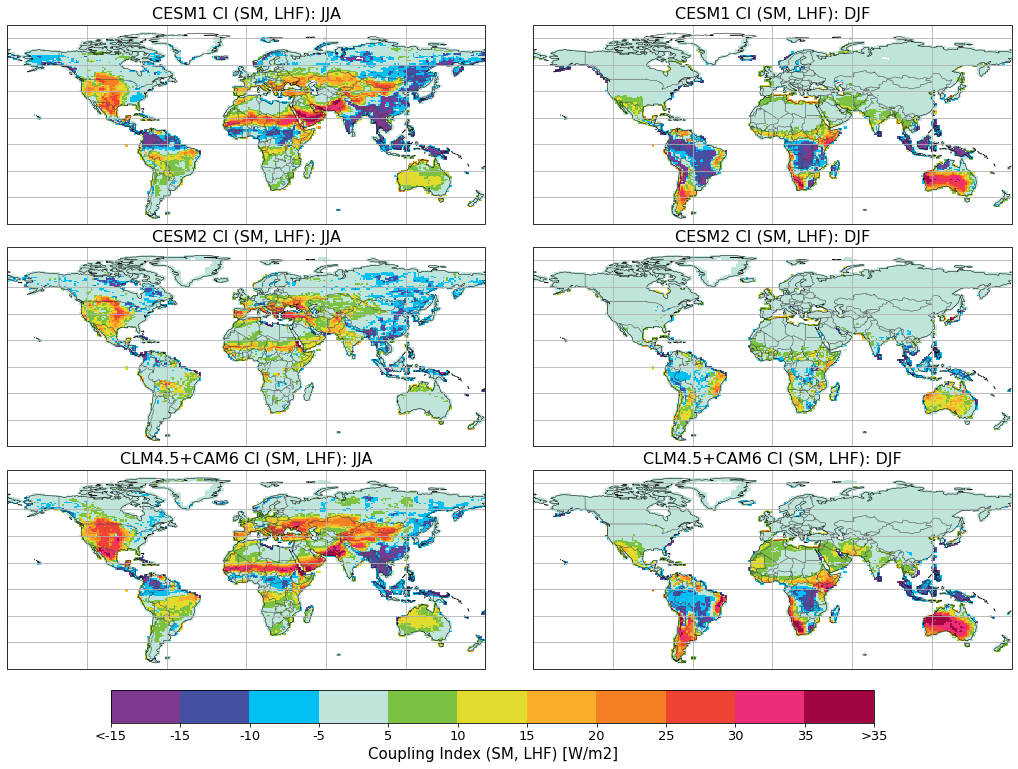

In [20]:
# Set up figure 
fig, axs = plt.subplots(3,2, figsize=(18, 15), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.4,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# ----- CESM1 panels -----  
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())       

# Set up color options 
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
                           
# Contour plots 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsSMvLHF_JJA_cesm1,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

contour_plot = axs[1].pcolormesh(lon_cyclic,lat,colorsSMvLHF_DJF_cesm1,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

# Additional options 
axs[0].set_title('CESM1 CI (SM, LHF): JJA',fontsize=16)
axs[1].set_title('CESM1 CI (SM, LHF): DJF',fontsize=16)

axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')

axs[0].gridlines()
axs[1].gridlines()

axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- CESM2 panels ----- 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())       

# Set up color options 
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# Contour Plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,colorsSMvLHF_JJA_cesm2,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

contour_plot = axs[3].pcolormesh(lon_cyclic,lat,colorsSMvLHF_DJF_cesm2,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

# Additional options 
axs[2].set_title('CESM2 CI (SM, LHF): JJA',fontsize=16)
axs[3].set_title('CESM2 CI (SM, LHF): DJF',fontsize=16)

axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')

axs[2].gridlines()
axs[3].gridlines()

axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- CLM4.5 panels ----- 
# Set global-ish extent
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())       

# Set up color options 
bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# Contour Plots 
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsSMvLHF_JJA_clm45,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

contour_plot = axs[5].pcolormesh(lon_cyclic,lat,colorsSMvLHF_DJF_clm45,norm=norm,
                             cmap=my_cmap_SMvLHF,
                             vmin=1,vmax=12)

# Additional options 
axs[4].set_title('CLM4.5+CAM6 CI (SM, LHF): JJA',fontsize=16)
axs[5].set_title('CLM4.5+CAM6 CI (SM, LHF): DJF',fontsize=16)

axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')

axs[4].gridlines()
axs[5].gridlines()

axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.08, ax_position.y0-0.05, ax_position.width+0.22, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, LHF) [W/m2]',fontsize=15)
cbar.ax.set_xticklabels(['<-15','-15','-10','-5','5','10', '15','20','25','30','35','>35'],fontsize=13)  # vertically oriented colorbar

plt.show()

# Save out to file
# fileDir = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Figures/'
# fig.savefig(fileDir+'CESM1v2_CouplingIndex_SM-LHF_'+timeStr+'.png')
